In [61]:
import argparse
import os

import numpy as np
import pandas as pd
import matplotlib

import matplotlib.pyplot as plt

from mapie.classification import MapieClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from src.conformal_prediction.utils import chunked_mapie_predict

# For loading your trained TransformerClassifier
from src.training.model import TransformerClassifier
from src.utils import load_config, get_logger

In [62]:
# Load config
env = "prod"
model_type = "BERT"

training_config = load_config(
    file_name="training_config", env=env, folder="../../config"
)

In [63]:
input_dataset = f"../../output_data/{env}/supervised_dataset.parquet"
input_model = f"../../output_models/{env}/trained_model"
input_outliers = f"../../output_data/{env}/supervised_dataset_phase2.parquet"
output_reports = f"../../output_reports/{env}/outlier_detection"
alpha = 0.2

In [64]:
df = pd.read_parquet(input_dataset)

In [65]:
# Select features and target
X = df[training_config.training[model_type].features]
y = df[training_config.training[model_type].target]
num_labels = y.nunique()

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=training_config.training[model_type].test_size,
    random_state=training_config.training.random_state,
    stratify=y,
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=training_config.training[model_type].val_size,
    random_state=training_config.training.random_state,
    stratify=y_train,
)
X_test, X_cp, y_test, y_cp = train_test_split(
    X_test,
    y_test,
    test_size=training_config.training[model_type].cp_size,
    random_state=training_config.training.random_state,
    stratify=y_test,
)

In [67]:
outliers = pd.read_parquet(input_outliers)
X_outliers = outliers[training_config.training[model_type].features]
y_outliers = outliers[training_config.training[model_type].target]
X_test = pd.concat([X_test, X_outliers], ignore_index=True)
y_test = pd.concat([y_test, y_outliers], ignore_index=True)

In [8]:
# Sample X_test and y_test
X_test = X_test.sample(
    frac=0.1, random_state=training_config.training.random_state
).reset_index(drop=True)
y_test = y_test.sample(
    frac=0.1, random_state=training_config.training.random_state
).reset_index(drop=True)

In [68]:
X_test.shape

(563,)

In [69]:
clf = TransformerClassifier(local_model_path=input_model, num_labels=num_labels)

In [70]:
# Prepare the model for conformal prediction
mapie_clf = MapieClassifier(
    estimator=clf,
    method="score",
    cv="prefit",
    random_state=training_config.training.random_state,
)

In [71]:
# Fit on the calibration set
_ = mapie_clf.fit(X_cp, y_cp)

In [72]:
alpha = [0.2, 0.15, 0.1]
point_preds, conf_sets = chunked_mapie_predict(mapie_clf, X_test, alpha=alpha)

In [73]:
def plot_scores(n, alphas, scores, quantiles):
    colors = {0: "#1f77b4", 1: "#ff7f0e", 2: "#2ca02c"}
    plt.figure(figsize=(7, 5))
    plt.hist(scores, bins="auto")
    for i, quantile in enumerate(quantiles):
        plt.vlines(
            x=quantile,
            ymin=0,
            ymax=100,
            color=colors[i],
            ls="dashed",
            label=f"alpha = {alphas[i]}",
        )
    plt.title("Distribution of scores")
    plt.legend()
    plt.xlabel("Scores")
    plt.ylabel("Count")
    plt.show()

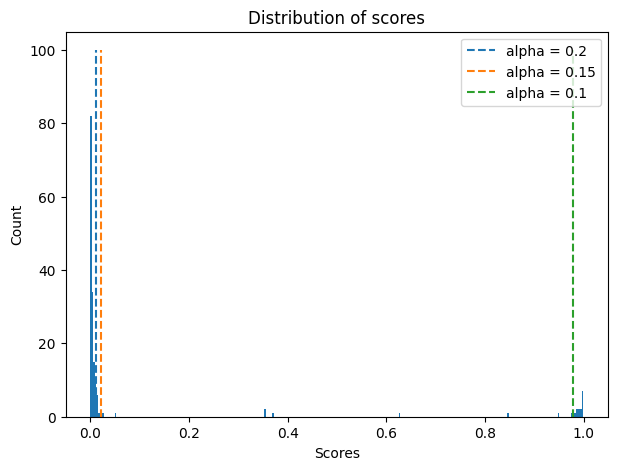

In [74]:
scores = mapie_clf.conformity_scores_
n = len(mapie_clf.conformity_scores_)
quantiles = mapie_clf.quantiles_

plot_scores(n, alpha, scores, quantiles)

# Analyze Outliers

In [93]:
from sklearn.metrics import (
    confusion_matrix,
    f1_score,
    recall_score,
    precision_score,
    accuracy_score,
)

alpha = [0.2]

for alpha_idx in range(len(alpha)):

    print("Running outlier detection for alpha =", alpha[alpha_idx])

    outlier_test = pd.concat([X_test, y_test], axis=1)
    outlier_test["true_outlier"] = y_test.apply(lambda x: 0 if x in [0, 1] else 1)

    outlier_test["outlier"] = False
    if conf_sets is not None and conf_sets.ndim == 3:
        for i in range(len(outlier_test)):
            label_boolean = conf_sets[i, :, alpha_idx]  # shape: (n_classes,)
            set_size = np.sum(label_boolean)
            if set_size != 1:
                outlier_test.loc[outlier_test.index[i], "outlier"] = True
    else:
        print("No valid conformal sets returned. No outliers flagged.")

    # Save outliers to a parquet file
    outliers_df = outlier_test[outlier_test["outlier"]]
    os.makedirs(output_reports, exist_ok=True)
    outliers_file = os.path.join(output_reports, "detected_outliers.parquet")
    outliers_df.to_parquet(outliers_file, index=False)

    if conf_sets is not None:
        set_sizes = []
        for i in range(outlier_test.shape[0]):
            if outlier_test["outlier"].iloc[i] is not None:
                # measure how big the set is
                label_boolean = conf_sets[i, :, alpha_idx]
                set_size = np.sum(label_boolean)
                set_sizes.append(set_size)

        plt.figure(figsize=(8, 6))
        plt.hist(
            set_sizes,
            bins=range(1, max(set_sizes) + 2),
            color="skyblue",
            edgecolor="black",
        )
        plt.title("Distribution of Conformal Set Sizes (alpha=0.15)")
        plt.xlabel("Set size")
        plt.ylabel("Frequency")
        plt.xticks(range(1, max(set_sizes) + 2))
        dist_plot_path = os.path.join(
            output_reports, "conformal_set_size_distribution.png"
        )
        plt.savefig(dist_plot_path)
        plt.close()
        # plt.show()

    if outliers_df.shape[0] > 0:
        outliers_by_class = (
            outliers_df.groupby(training_config.training[model_type].target)
            .size()
            .sort_values(ascending=False)
        )
        plt.figure(figsize=(10, 6))
        outliers_by_class.plot(kind="bar", color="tomato")
        plt.title("Number of Outliers by True Label")
        plt.xlabel("Label")
        plt.ylabel("Count of Outliers")
        outliers_bar_path = os.path.join(output_reports, "outliers_by_class.png")
        plt.savefig(outliers_bar_path)
        plt.close()
        # plt.show()

    if "true_outlier" in outlier_test.columns:
        # Convert booleans => int
        y_true = outlier_test["true_outlier"].astype(int).values
        y_pred = outlier_test["outlier"].astype(int).values

        # Compute metrics
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        cls_report = classification_report(y_true, y_pred, zero_division=0)

        # Log to a text file
        eval_report_file = os.path.join(output_reports, "outlier_evaluation_report.txt")
        with open(eval_report_file, "w", encoding="utf-8") as f:
            f.write("Outlier Detection: Binary Classification Evaluation\n")
            f.write("--------------------------------------------------\n\n")
            f.write(f"Accuracy:  {acc:.4f}\n")
            f.write(f"Precision: {prec:.4f}\n")
            f.write(f"Recall:    {rec:.4f}\n")
            f.write(f"F1-Score:  {f1:.4f}\n\n")
            f.write("Full Classification Report:\n")
            f.write(f"{cls_report}\n")
        print("Outlier Detection: Binary Classification Evaluation\n")
        print("--------------------------------------------------\n\n")
        print(f"Accuracy:  {acc:.4f}\n")
        print(f"Precision: {prec:.4f}\n")
        print(f"Recall:    {rec:.4f}\n")
        print(f"F1-Score:  {f1:.4f}\n\n")
        print("Full Classification Report:\n")
        print(f"{cls_report}\n")

        print(f"Outlier evaluation report saved to {eval_report_file}")

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(5, 4))
        plt.imshow(cm, cmap=plt.cm.Blues)
        plt.title("Outlier Detection Confusion Matrix")
        plt.colorbar()
        ticks = np.arange(2)
        plt.xticks(ticks, ["Normal (0)", "Outlier (1)"], rotation=45, ha="right")
        plt.yticks(ticks, ["Normal (0)", "Outlier (1)"])
        # Print counts inside squares
        thresh = cm.max() / 2.0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(
                    j,
                    i,
                    format(cm[i, j], "d"),
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black",
                )
        plt.tight_layout()
        plt.xlabel("Predicted label")
        plt.ylabel("True label")

        cm_path = os.path.join(output_reports, "outlier_detection_confusion_matrix.png")
        plt.savefig(cm_path)
        plt.close()
        # plt.show()
    else:
        print(
            "No 'true_outlier' column found in data. Skipping binary classification evaluation."
        )

Running outlier detection for alpha = 0.2
Outlier Detection: Binary Classification Evaluation

--------------------------------------------------


Accuracy:  0.3766

Precision: 0.7111

Recall:    0.1645

F1-Score:  0.2672


Full Classification Report:

              precision    recall  f1-score   support

           0       0.31      0.85      0.46       174
           1       0.71      0.16      0.27       389

    accuracy                           0.38       563
   macro avg       0.51      0.51      0.36       563
weighted avg       0.59      0.38      0.33       563


Outlier evaluation report saved to ../../output_reports/prod/outlier_detection\outlier_evaluation_report.txt


In [86]:
from src.conformal_prediction.utils import generate_cp_results, reduce_dimensions

if conf_sets is not None:
    print("Saving conformal prediction results.")
    X_train_reduced = reduce_dimensions(X_cp, method="pca")
    X_test_reduced = reduce_dimensions(
        outlier_test[training_config.training[model_type].features], method="pca"
    )

    results_plot_path = generate_cp_results(
        X_train=X_train_reduced,
        y_train=y_cp,
        X_test=X_test_reduced,
        alphas=alpha,
        y_pred_mapie=point_preds,
        y_ps_mapie=conf_sets,
        output_reports=output_reports,
    )
    print(f"Conformal prediction results saved to: {results_plot_path}")

Saving conformal prediction results.


ValueError: Input embeddings must be a pandas DataFrame or numpy array.